In [1]:
from IPython import display

import msprime
import numpy as np
import tskit

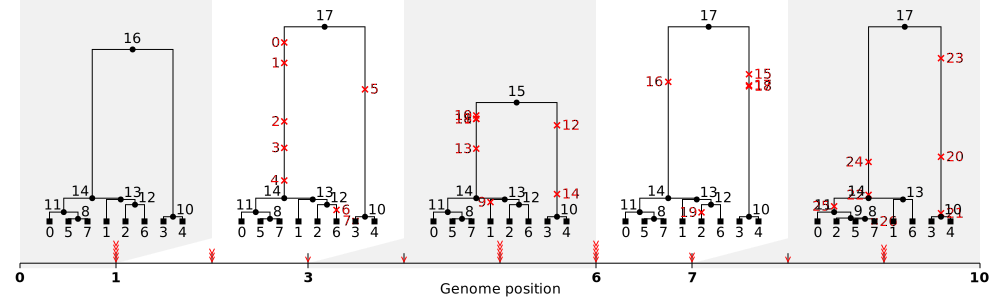

In [2]:
ts = msprime.sim_ancestry(samples=4, recombination_rate=0.2, sequence_length=10, random_seed=1)
ts = msprime.sim_mutations(ts, rate=.5, random_seed=1)
ts.draw_svg(size=(1000, 300))

In [3]:
def next_state_at(ts, tj, tk, t_left, tree_index, sample_sets, parent=None, state=None):
    I = ts.indexes_edge_insertion_order
    O = ts.indexes_edge_removal_order
    parent = -np.ones(ts.num_nodes, dtype=np.int32) if parent is None else parent

    state = np.zeros((ts.num_nodes, len(sample_sets)), dtype=np.int32) if state is None else state

    for i, sample_set in enumerate(sample_sets):
        state[sample_set, i] = 1
    
    while (tk < ts.num_edges) and (ts.edges_right[O[tk]] == t_left):
        h = O[tk]
        tk += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
    
        while (v != -1):
            # print(state[u])
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: red; stroke-width: 2px}}'))
            state[v] += -state[u]
            v = parent[v]
        parent[u] = -1
    while (tj < ts.num_edges) and (ts.edges_left[I[tj]] == t_left):
        h = I[tj]
        tj += 1
        u = ts.edges_child[h]
        v = ts.edges_parent[h]
        parent[u] = v
        while (v != -1):
            # print(state[u])
            # display.display(ts.draw_svg(size=(1000, 300), style=f'.a{v}.n{u} > .edge {{stroke: cyan; stroke-width: 2px}}'))
            state[v] += state[u]
            v = parent[v]
    t_right = ts.sequence_length
    if (tj < ts.num_edges):
        t_right = min(t_right, ts.edges_left[I[tj]])
    if (tk < ts.num_edges):
        t_right = min(t_right, ts.edges_right[O[tk]])

    t_left = t_right
    return ts, tj, tk, t_left, tree_index, state

In [9]:
sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]

allele_state = []

tj_left = 0
tk_left = 0
t_left_left = 0
tree_index_left = 0
parent_left = None
state_left = None

tj_right = 0
tk_right = 0
t_right_right = 0
tree_index_right = 0
parent_right = None
state_right = None

while (tj_left < ts.num_edges) or (t_left_left < ts.sequence_length):
    treeseq_state_left = next_state_at(
        ts=ts, tj=tj_left, tk=tk_left, t_left=t_left_left,
        tree_index=tree_index_left, sample_sets=sample_sets, parent=parent_left, state=state_left
    )
    ts_left, tj_left, tk_left, t_left_left, tree_index_left, state_left = treeseq_state_left

    for site in ts.at_index(tree_index_left).sites():
        allele_mat = np.zeros((len(site.mutations) + 1, len(sample_sets)))
        allele_states = [site.ancestral_state]
        allele = 0
        allele_mat[allele] = np.array(list(map(len, sample_sets)))
        for mutation in site.mutations:

            if mutation.derived_state in allele_states:
                allele = allele_states.index(mutation.derived_state)
            else:
                allele_states.append(mutation.derived_state)
                allele = len(allele_states) - 1
            allele_mat[allele] += state[mutation.node]

            alt_allele = allele_states.index(site.ancestral_state)
            if mutation.parent != -1:
                # TODO haven't exercised this code path yet
                alt_allele = allele_states.index(site.mutations[mutation.parent - site.mutations[0].id].derived_state)
            allele_mat[alt_allele] -= state[mutation.node]

        allele_state.append((len(allele_states), allele_mat))

    tree_index_left += 1

# for _n_alleles, _a_state in allele_state:
#     print(_a_state)
# sample_sets = [[0, 1, 2], [3, 4, 5], [4, 5, 6], [1, 2]]

NameError: name 'state' is not defined

In [5]:
def diversity_summary_func(state, sample_sets):
    x = state
    n = np.array([len(ss) for ss in sample_sets])  # sample_set_sizes
    return x * (n - x) / (n * (n - 1))

In [26]:
stats = []
for _n_alleles, _a_state in allele_state:
    for i in range(_n_alleles):  # If polarized, range from 1
        stats.append(diversity_summary_func(_a_state[i], sample_sets))

In [27]:
np.vstack(stats).sum(0)

ValueError: need at least one array to concatenate

In [7]:
# display.display(display.Markdown("# Edge Insertion Order"))
# for i in I:
#     edge = ts.edge(i)
#     display.display(ts.draw_svg(style=f'.a{edge.parent}.n{edge.child} > .edge {{stroke: cyan; stroke-width: 2px}}'))

In [8]:
# display.display(display.Markdown("# Edge Removal Order"))
# for i in O:
#     edge = ts.edge(i)
#     display.display(ts.draw_svg(style=f'.a{edge.parent}.n{edge.child} > .edge {{stroke: cyan; stroke-width: 2px}}'))